##  Analysis of a claim
To Check on Checkability, the first workflow of the EUFactcheck programme will be followed (https://eufactcheck.eu/about-us/eufactcheck-flowchart/). The student will also be involved to provide more information and to check the output.

In [10]:
import getpass
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
#from langchain_ollama import ChatOllama
import tqdm as notebook_tqdm

load_dotenv(dotenv_path=".env", override=True)

#os.environ["LANGSMITH_TRACING"] = "true"
#os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
#os.environ["LANGSMITH_PROJECT"]="pr-left-technician-100"

#low temperature for more factual answers,
#llm = ChatOllama(model="qwen3:4b", temperature=0.1, base_url="http://localhost:11434")
llm = ChatGroq(model_name="qwen/qwen3-32b", temperature=0.1)

import sys
import os
sys.path.append(os.path.abspath("./src"))

### AgentState and Pydantic schemes
The next part determines which data should be stored in AgentState (memory of the program), and how certain output should be structured using pydantic.

In [11]:
# #%%writefile ./src/state_scope.py
# """
# State Definitions and Pydantic Schemas for testing if a claim is checkable.

# This defines the state objects and structured schemas used for Checking on checkability and check worthiness
# of claims.
# """

# from typing_extensions import TypedDict, Annotated, Sequence, Literal, List, Optional
# from langchain_core.messages import BaseMessage
# from langchain_core.output_parsers import PydanticOutputParser
# from pydantic import BaseModel, Field
# from operator import add as add_messages
# from langgraph.graph.message import MessagesState

# # Input state for the full agent
# class AgentInputState(MessagesState):
#     """Input state for the full agent - only contains messages from user input."""
#     pass

# # Create an object to hold the state of the agent
# class AgentState(TypedDict):
#     """State for the full agent"""
#     messages: Annotated[Sequence[BaseMessage], add_messages]
#     claim: str 
#     checkable: Optional[bool]
#     subject: Optional[str]
#     quantitative: Optional[bool]
#     precision: Optional[str]
#     based_on: Optional[str]
#     confirmed: bool
#     question: Optional[str]
#     alerts: List[str] = Field(default_factory=list)
#     summary: Optional[str]
#     claim_author: Optional[str]
#     claim_source: Optional[str]
#     primary_source: Optional[str]
    
# #output models for structured output
# class SubjectResult(BaseModel):
#     checkable: Literal["POTENTIALLY CHECKABLE", "UNCHECKABLE"]
#     explanation: str
#     question: str = Field("", description="Question to user for confirmation")

# class MoreInfoResult(BaseModel):
#     subject: str
#     quantitative: bool
#     precision: str = Field("", description="How precise is it?")
#     based_on: str = Field("", description="how was the data collected or derived?")
#     explanation: str
#     question: str = Field("", description="Question to user for clarification if needed")
#     alerts: List[str] = Field([], description="Any alerts or warnings about the claim")

# class SummaryResult(BaseModel):
#     summary: str
#     question: str = Field("", description="Question to user for verification")

# class ConfirmationResult(BaseModel):
#     confirmed: bool = Field(False, description="Whether the user confirmed a step in the process")

### Functions of all the nodes in Claim analysis

These functions are all the nodes in the claim graph and also show the edges in case of conditional nodes

In [ ]:
#%%writefile ./src/state_checkable_nodes.py

"""Nodes for checking if a claim is potentially checkable."""

from langchain_core.messages import HumanMessage,AIMessage,get_buffer_string
from prompts import checkable_check,confirmation_checkable, get_information, confirmation_clarification, get_summary, confirmation_check
from state_scope import AgentStateClaim, SubjectResult, MoreInfoResult, SummaryResult, ConfirmationResult,ConfirmationFinalResult
from typing_extensions import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.types import Command

# ───────────────────────────────────────────────────────────────────────
# CHECKABLE_FACT NODE
# ───────────────────────────────────────────────────────────────────────

def checkable_fact(state: AgentStateClaim) -> Command[Literal["checkable_confirmation"]]:
    
    """ Check if a claim is potentially checkable. """

    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(SubjectResult, method="json_mode")

    # System prompt for checkability
    checkable_prompt  =  checkable_check.format(
        claim=state.get("claim", ""),
        messages=get_buffer_string(state.get("messages", [])),
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=checkable_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())

    # checkable is a boolean in State
    is_checkable = result.checkable == "POTENTIALLY CHECKABLE"

    # print output
    print("\n=== 1. CHECKABLE? ===")
    print(f"{result.checkable}")
    print(f"{result.explanation}")
    print(f"{result.question}")


    return Command(
        goto="checkable_confirmation", 
        update={
            "question": result.question,
            "checkable": is_checkable,
            "messages": list(state.get("messages", [])) + [ai_msg],
        }
    )

# ───────────────────────────────────────────────────────────────────────
# CHECKABLE_CONFIRMATION NODE
# ───────────────────────────────────────────────────────────────────────

def checkable_confirmation(state: AgentStateClaim) -> Command[Literal["retrieve_information","__end__","checkable_fact"]]:
   
    """ Get confirmation from user on the gathered information. """

    #Retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and ethe messages as output
    structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

    # System prompt for checkability
    confirmation_prompt  =  confirmation_checkable.format(
        claim=state.get("claim", ""),
        checkable=state.get("checkable", ""),
        explanation=state.get("explanation", ""),
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=confirmation_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print(f"confirmed: {result.confirmed}")
    

    if result.confirmed:
        if state.get("checkable"):
            return Command(
                    goto="retrieve_information", 
                    update={
                        "confirmed": result.confirmed,
                        "messages": conversation_history + [ai_msg],
                    }
            )   
        else: 
            print("Since this claim is uncheckable, we will end the process here.")
            return Command(
                    goto=END, 
                    update={
                        "confirmed": result.confirmed,
                        "messages": conversation_history + [ai_msg],
                    }
            )   
    else:
        return Command(
                goto="checkable_fact", 
                update={
                    "messages": conversation_history + [ai_msg],
                }
        )
    
# ───────────────────────────────────────────────────────────────────────
# RETRIEVE_INFORMATION NODE
# ───────────────────────────────────────────────────────────────────────
           
def retrieve_information(state: AgentStateClaim) -> Command[Literal["clarify_information"]]:
    
    """ Gather more information about a potentially checkable claim. """

    # Use structured output to get aal the details as output
    structured_llm = llm.with_structured_output(MoreInfoResult, method="json_mode")


    # System prompt for checkability
    information_prompt  =  get_information.format(
        claim=state.get("claim", ""),
        messages=get_buffer_string(state.get("messages", [])),
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=information_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print("\n=== 2. Evidence retrieved? ===")
    print(f"subject: {result.subject}")
    print(f"quantitative: {result.quantitative}")
    print(f"precision: {result.precision}")
    print(f"based on: {result.based_on}")
    print(f"question: {result.question}")
    print(f"alerts: {result.alerts}")

    return Command(
        goto="clarify_information", 
        update={
            "subject": result.subject,
            "quantitative": result.quantitative,
            "precision": result.precision,
            "based_on": result.based_on,
            "question": result.question,
            "alerts": result.alerts or [],
        }
    )   

# ───────────────────────────────────────────────────────────────────────
# CLARIFY_INFORMATION NODE
# ───────────────────────────────────────────────────────────────────────

def clarify_information(state: AgentStateClaim) -> Command[Literal["produce_summary", "retrieve_information"]]:
   
    """ Get confirmation from user on the gathered information. """
    #retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    #retreive conversation history
    conversation_history = list(state.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(ConfirmationResult, method="json_mode")

    # System prompt for checkability
    confirmation_prompt  =  confirmation_clarification.format(
        subject=state.get("subject", ""),
        quantitative=state.get("quantitative", ""),
        precision=state.get("precision", ""),
        based_on=state.get("based_on", ""),
        claim=state.get("claim", ""),
        question=state.get("question", ""),
        alerts=alerts_str,
        messages=conversation_history,
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=confirmation_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print(f"confirmed: {result.confirmed}")
    

    if result.confirmed:
        return Command(
                goto="produce_summary", 
                update={
                    "confirmed": result.confirmed,
                    "messages": conversation_history + [ai_msg],
                }
        )       
    else:
        return Command(
                goto="retrieve_information", 
                update={
                    "messages": conversation_history + [ai_msg],
                }
        )

# ───────────────────────────────────────────────────────────────────────
# PRODUCE SUMMARY NODE
# ───────────────────────────────────────────────────────────────────────

def produce_summary(state: AgentStateClaim) -> Command[Literal["get_confirmation"]]:
    
    """ Get a summary on the gathered information. """

   #retrieve alerts and format to string for the prompt
    alerts=state.get("alerts", [])
    alerts_str= "\n".join(f"- {a}" for a in alerts)

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))


    # Use structured output to get all details the messages as output
    structured_llm = llm.with_structured_output(SummaryResult, method="json_mode")

    # System prompt for checkability
    confirmation_prompt  =  get_summary.format(
        claim=state.get("claim", ""),
        subject=state.get("subject", ""),
        quantitative=state.get("quantitative", ""),
        precision=state.get("precision", ""),
        based_on=state.get("based_on", ""),
        alerts=alerts_str,
        messages=conversation_history ,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=confirmation_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())


    # print output
    print("\n=== 3. SUMMARY ===")
    print(f"To verify, this is a summary of our discussion: {result.summary}")
    print(f"{result.question}")
       
    return Command( 
            update={
                "summary": result.summary,
                "question": result.question,
                "messages": list(state.get("messages")) + [ai_msg],
                "subject": result.subject,
                "quantitative": result.quantitative,
                "precision": result.precision,
                "based_on": result.based_on,
                "alerts": result.alerts or []
            }
    )       
    
# ───────────────────────────────────────────────────────────────────────
# GET_CONFIRMATION NODE
# ───────────────────────────────────────────────────────────────────────
#    
def get_confirmation(state: AgentStateClaim) -> Command[Literal["produce_summary", "__end__"]]:
   
    """ Get confirmation from user on the gathered information."""

    # retrieve conversation history
    conversation_history = list(state.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and all details as output
    structured_llm = llm.with_structured_output(ConfirmationFinalResult, method="json_mode")

    # System prompt for checkability
    confirmation_prompt  =  confirmation_check.format(
        summary=state.get("summary", ""),
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=confirmation_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)


    # print output
    print(f"confirmed: {result.confirmed}")

    if result.confirmed:
        return Command(
                goto=END, 
                update={
                    "confirmed": result.confirmed,
                    "subject": result.subject,
                    "quantitative": result.quantitative,
                    "precision": result.precision,
                    "based_on": result.based_on,
                    "question": result.question,
                    "alerts": result.alerts or [],
                    "messages": conversation_history,
                    
                }
        )       
    else:
        return Command(
                goto="produce_summary", 
                update={
                    "messages":  conversation_history,
                    "subject": result.subject,
                    "quantitative": result.quantitative,
                    "precision": result.precision,
                    "based_on": result.based_on,
                    "question": result.question,
                    "alerts": result.alerts or [],
                }
        )

### Claim analysis graph

Build the claim analysis graph, that takes the user step by step through analysing and scoping the claim.

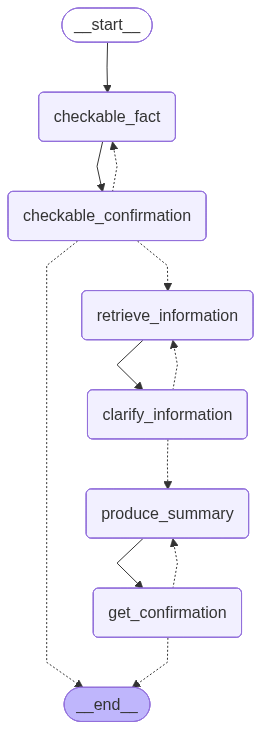

In [13]:
"""
Claim graph flow

"""

claim = StateGraph(AgentStateClaim)

claim.add_node("checkable_fact", checkable_fact)
claim.add_node("checkable_confirmation", checkable_confirmation)
claim.add_node("retrieve_information", retrieve_information)
claim.add_node("clarify_information", clarify_information)
claim.add_node("produce_summary", produce_summary)
claim.add_node("get_confirmation", get_confirmation)

# Entry point
claim.add_edge(START, "checkable_fact")
claim.add_edge("checkable_fact", "checkable_confirmation")
claim.add_edge("retrieve_information", "clarify_information")
claim.add_edge("produce_summary", "get_confirmation")
claim.add_edge("get_confirmation", END)

claim_flow = claim.compile()

#visualization
try:
    from IPython.display import Image, display
    display(Image(claim_flow.get_graph().draw_mermaid_png()))
except Exception:
    pass


## Analyse author and source

To analyse the author and source of the claim, the first workflow of the EUFactcheck programme will be followed (https://eufactcheck.eu/about-us/eufactcheck-flowchart/). The student will also be involved to provide more information and to check the output.

First load the Faiss database, which contains allready fact-checked claims, from different Fact checking organizations. And set it up as a retriever.

In [14]:
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# Load existing FAISS index
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
vectorstore = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

# Set up retriever
retriever = vectorstore.as_retriever()

### Tools section

Create a retriever tool, one that also checks the article behind the url, since only the url resides in the Faiss database. 
Furthermore the url's are seperated in ALLOWED URL's to ensure that the exact url is cited from the Database. This to prevent hallucinated url's.

In [ ]:
from langchain.tools import tool
from utils import format_docs
import json

@tool
# ───────────────────────────────────────────────────────────────────────
# RETRIEVER TOOL
# ───────────────────────────────────────────────────────────────────────
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns information from the FACTors dataset.
    It returns two blocks as one string:
    1) CONTEXT: numbered snippets without URLs
    2) ALLOWED_URLS: a JSON dictionary of index -> url that the model must cite by index only
    """
    print(f"\n--retriever called, query: {query}--\n")
    docs = retriever.invoke(query)
    context_block = format_docs(docs)

    # Build a list of allowed URLs, and index them.
    urls = [d.metadata.get("url", "") for d in docs if d.metadata.get("url")]
    allowed = dict(enumerate(urls))
    print(f"Allowed URLs: {allowed}")

    # Return a single string so your existing tool plumbing still works.
    return (
        "CONTEXT (read-only; do NOT copy or invent URLs):\n"
        f"{context_block}\n\n"
        "ALLOWED_URLS (index -> url):\n"
        f"{json.dumps(allowed, indent=2)}\n\n"
        "INSTRUCTIONS: When citing, use indices from ALLOWED_URLS only (e.g., [0], [2]). "
        "Do not output raw URLs unless they come from ALLOWED_URLS."
    )

# ───────────────────────────────────────────────────────────────────────
# TAVILY SEARCH TOOL (new)
# ───────────────────────────────────────────────────────────────────────
@tool
def tavily_search(query: str) -> str:
    """
    General-purpose web search using Tavily.
    Use this when the user gives a source (URL, outlet, author, platform) and subject.
    Returns a JSON-like text block with titles, urls and snippets.
    """
    print(f"\n--tavily_search called, query: {query}--\n")
    if not query or not query.strip():
        return "No query provided."

    resp = tavily_client.search(
        query=query,
        max_results=5,
        search_depth="advanced",
        include_raw_content=False,
    )

    # resp looks like: {"results": [...], "query": "...", ...}
    # To match your current pattern, we return a single string.
    results = resp.get("results", [])
    return json.dumps(
        {
            "SOURCE": "tavily",
            "query": query,
            "results": results,
            "INSTRUCTIONS": (
                "Cite using the URLs in `results`. Do NOT invent URLs. "
                "Prefer the most relevant/high-authority result."
            ),
        },
        indent=2,
    )


# ───────────────────────────────────────────────────────────────────────
# BIND BOTH TO LLM
# ───────────────────────────────────────────────────────────────────────
tools = [retriever_tool, tavily_search]
llm_tools = llm.bind_tools(tools)

# Dict for lookup by name
tools_dict = {our_tool.name: our_tool for our_tool in tools}
print(f"\n--tools registered: {list(tools_dict.keys())}--\n")




--{'retriever_tool': StructuredTool(name='retriever_tool', description='This tool searches and returns information from the FACTors dataset.\nIt returns two blocks as one string:\n1) CONTEXT: numbered snippets without URLs\n2) ALLOWED_URLS: a JSON dictionary of index -> url that the model must cite by index only', args_schema=<class 'langchain_core.utils.pydantic.retriever_tool'>, func=<function retriever_tool at 0x000002BDA866A700>)}--



### Functions of all the nodes in Author and Source analysis

These functions are all the nodes in the author and source graph and also show the edges in case of conditional nodes.

In [ ]:
from prompts import retrieve_claims, match_check, identify_source
from langchain_core.messages import HumanMessage, ToolMessage,AIMessage
from state_scope import AgentStateSource, ConfirmationMatch, GetSource

# ───────────────────────────────────────────────────────────────────────
# CLAIM MATCHING NODE
# ───────────────────────────────────────────────────────────────────────

def claim_matching(stateSource: AgentStateSource) -> Command[Literal["match_or_continue"]]:
    
    """ Call the retriever tool iteratively to find if similar claims have already been researched. """

    # retrieve conversation history
    conversation_history = list(stateSource.get("messages", []))

    # Get the summary of the previous steps
    summary = stateSource.get("summary", "")
    subject = stateSource.get("subject", "")

    # System prompt for checkability
    retrieve_claims_prompt  =  retrieve_claims.format(
        summary=summary,
        subject=subject,
    )
   
    # Start with a single HumanMessage
    human = HumanMessage(content=retrieve_claims_prompt)

    # First model call: only the prompt
    result = llm_tools.invoke([human])

    # Keep a log in state (messages must be BaseMessage objects)
    conversation_history.append(result)   

    # Iterate tool calls
    while getattr(result, "tool_calls", None):

        # empty tool messages list to contain tool outputs
        tool_msgs: List[ToolMessage] = []
        
        # loop over echt tool call
        for t in result.tool_calls:
            name = t["name"]
            args = t.get("args") or {}

            # invoke the tool
            out = tools_dict[name].invoke(args)

            # append tool output as ToolMessage
            tool_msgs.append(
                ToolMessage(
                    tool_call_id=t["id"],
                    name=name,
                    content=str(out),
                )
            )

        # Next model call, and decide if more tool calls are needed
        result = llm_tools.invoke([human, result, *tool_msgs])
      
        print(result.content)
        print("Do one of the claims match? Or do you want to continue researching?")

        # Log messages to conversation history
        conversation_history.append(result)


    return Command( 
            update={
                "goto":"match_or_continue",
                "messages": conversation_history
            }
    )  

# ───────────────────────────────────────────────────────────────────────
# MATCHED OR CONTUE RESEARCH NODE
# ───────────────────────────────────────────────────────────────────────

def match_or_continue(stateSource: AgentStateSource) -> Command[Literal["get_source", "__end__"]]:
   
    """ Decide whether to continue researching or end the process if a matching claim was found."""

    # retrieve conversation history
    conversation_history = list(stateSource.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and all details as output
    structured_llm = llm.with_structured_output(ConfirmationMatch, method="json_mode")

    # System prompt for checkability
    matching_prompt  =  match_check.format(
        messages=conversation_history,
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=matching_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)


    # print output
    print(f"confirmed: {result.match}")
    print(f"confirmed: {result.explanation}")

    if result.match:
        print("Since this claim has already been researched, we will end the process here.")
        return Command(
                goto=END, 
                update={
                    "match": result.match,
                    "explanation": result.explanation,
                    "messages": conversation_history,  
                }
        )       
    else:
        print("Since no matching claim was found, we'll continue researching.")
        print("Do you have a URL for the source of the claim? If so, please share it.")
        print("If not, could you tell me who the author/ source is and what medium the claim appeared in (e.g., article, video, social media post)?")
        return Command(
                goto="get_source", 
                update={
                    "explanation": result.explanation,
                    "messages": conversation_history,  
                }
        )
    
# ───────────────────────────────────────────────────────────────────────
# RETRIEVE SOURCE
# ───────────────────────────────────────────────────────────────────────

def get_source(stateSource: AgentStateSource) -> Command[Literal["get_more_info"]]:
   
    """ Ask the user for the original source of the claim if no match was found."""

    # retrieve conversation history
    conversation_history = list(stateSource.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and all details as output
    structured_llm = llm.with_structured_output(GetSource, method="json_mode")

    # System prompt for checkability
    source_prompt  =  identify_source.format(
        messages=conversation_history,
        user_answer=user_answer,
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=source_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)


    # print output
    if {result.claim_author}!= "":
        print("Is the author/ source {result.claim_source} an expert, a lobiest, an NGO, government, opposition, civil service, think tank, a company or a citizen?")
        print("Do you know if this is the orignal primary source?")

    return Command(
            goto=END, 
            update={
                "claim_source": result.claim_source,
                "claim_url": result.claim_url,
                "messages": conversation_history,
            }
    ) 

# ───────────────────────────────────────────────────────────────────────
# GET MORE INFO
# ───────────────────────────────────────────────────────────────────────

def get_more_info(stateSource: AgentStateSource) -> Command[Literal["__end__"]]:
   
    """ Ask the user for the original source of the claim if no match was found."""

    # retrieve conversation history
    conversation_history = list(stateSource.get("messages", []))

    # Get user's reply
    user_answer = input("> ")
    conversation_history.append(HumanMessage(content=user_answer))


    # Use structured output to get a boolean and all details as output
    structured_llm = llm.with_structured_output(GetSource, method="json_mode")

    # System prompt for checkability
    source_prompt  =  identify_source.format(
        messages=conversation_history,
        user_answer=user_answer,
        claim_source=stateSource.get("claim_source", ""),
        summary = stateSource.get("summary", ""),
        subject = stateSource.get("subject", ""),
        claim_url = stateSource.get("claim_url", "")
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=source_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())
    conversation_history.append(ai_msg)


    # print output
    return Command(
            goto=END, 
            update={
                "claim_source": result.claim_source,
                "claim_author": result.claim_author,  
            }
    )       

### Claim analysis graph

Build the claim analysis graph, that takes the user step by step through analysing and scoping the claim.

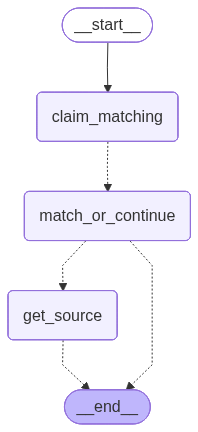

In [17]:
"""
Source graph flow

"""

source = StateGraph(AgentStateSource)

source.add_node("claim_matching", claim_matching)
source.add_node("match_or_continue", match_or_continue)
source.add_node("get_source", get_source)

# Entry point
source.add_edge(START, "claim_matching")
source.add_edge("claim_matching", "match_or_continue")
source.add_edge("match_or_continue", "get_source")
source.add_edge("get_source", END)

source_flow = source.compile()

#visualization
try:
    from IPython.display import Image, display
    display(Image(source_flow.get_graph().draw_mermaid_png()))
except Exception:
    pass


## Main program

This is the main program, tying everything together

In [ ]:
"""
Main program to run the agent interactively.
"""

def running_agent():
    conversation_history: List[BaseMessage] = []

    # ───────────────────────────────────────────────────────────────────────
    # CLAIM ANALYSIS FLOW
    # ───────────────────────────────────────────────────────────────────────
    # Get initial claim and KEEP it in history before first invoke
    user_input = input("\nWhat claim do you want to investigate? ")
    conversation_history.append(HumanMessage(content=user_input))

    # Initial state
    state: AgentStateClaim = {
        "messages": conversation_history,
        "claim": user_input,
        "checkable": None,
        "subject": None,
        "quantitative": None,
        "precision": None,
        "based_on": None,
        "confirmed": False,
        "question": None,
        "alerts": [],
        "summary": None,
    }

    #show the claim
    print(f"CLAIM: {state.get('claim')}")

    # Run the graph to iteratite on the claim with input from user, this will result in a summary. 
    # This part is based on the first workflow of the EUFactcheck programme "Claim Analysis".
    result = claim_flow.invoke(state)

    # ───────────────────────────────────────────────────────────────────────
    # SOURCE AND AUTHOR FLOW
    # ───────────────────────────────────────────────────────────────────────

    # Run the graph to iteratite on the claim with input from user, this will result in a summary. 
    # This part is based on the second workflow of the EUFactcheck programme "Author and Source Analysis".
    # But we will first do some claim matching to see if similar claims have already been researched.

    # Starting state for second flow
    stateSource: AgentStateSource = {
        "messages": result.get("messages"),
        "claim": user_input,
        "checkable": True,
        "subject": result.get("subject", ""),
        "quantitative": result.get("quantitative", ""),
        "precision": result.get("precision", ""),
        "based_on": result.get("based_on", ""),
        "confirmed": False,
        "question": None,
        "alerts": result.get("alerts", []),
        "summary": result.get("summary", ""),
        "claim_url":None,
        "claim_source":None,
        "primary_source":False,
        "match": False
    }

    # Update rolling conversation
    conversation_history = list(stateSource.get("messages", []))

    result = source_flow.invoke(stateSource)

    # Update rolling conversation
    conversation_history = list(result["messages"])

    # Persist a readable log
    with open("logging.txt", "w", encoding="utf-8") as f:
        f.write("Your Conversation Log:\n")
        for m in conversation_history:
            if isinstance(m, HumanMessage):
                f.write(f"You: {m.content}\n")
            elif isinstance(m, AIMessage):
                f.write(f"AI: {m.content}\n\n")
        f.write("End of Conversation\n")

    print("Conversation saved to logging.txt")

    
# run it
running_agent()




CLAIM: Every 3rd refugee reaches Italy on a yacht on the eastern route

=== 1. CHECKABLE? ===
POTENTIALLY CHECKABLE
The claim is a factual statement about a specific statistic (1/3 of refugees using yachts on the eastern route to Italy), which can be verified with migration route and transportation data.
Does this classification correctly capture your claim as a factual statement about refugee migration patterns that can be verified with data?
confirmed: True

=== 2. Evidence retrieved? ===
subject: Refugees reaching Italy via the eastern route using yachts
quantitative: True
precision: precise
based on: unclear
question: What is the source of this statistic (e.g., official migration reports, NGO data, or other)?
alerts: ['methodological details absent', 'time period missing', 'geography: eastern route (present)']
confirmed: True

=== 3. SUMMARY ===
To verify, this is a summary of our discussion: The claim states that one-third of refugees arriving in Italy via the eastern route use ya